# **Instalamos las librerias necesarias para el analisis geografico.**

In [ ]:
#pip install contextily

In [ ]:
#pip install geopandas

In [ ]:
#pip install mapclassify

In [ ]:
pip install git+git://github.com/geopandas/geopandas.git

In [ ]:
pip install pygeos

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily
import geopandas
import pygeos
from shapely.geometry import Polygon
import mapclassify

In [2]:
from google.colab import drive
drive.mount('/content/drive/') 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [62]:
!ls '/content/drive/My Drive/CAECE_DATA/'

BA_barrios.geojson	bocas_de_subte.geojson	listings_BA.csv
barrios_airbnb.geojson	espacio_verde.geojson


Cargamos los archivos que vamos a usar

In [63]:
#datos AIRBNB
barrios_airbnb = geopandas.read_file('/content/drive/My Drive/CAECE_DATA/barrios_airbnb.geojson')
airbnb = pd.read_csv('/content/drive/My Drive/CAECE_DATA/listings_BA.csv')

#datos BA
subtes = geopandas.read_file('/content/drive/My Drive/CAECE_DATA/bocas_de_subte.geojson')
barrios = geopandas.read_file('/content/drive/My Drive/CAECE_DATA/BA_barrios.geojson')
espacios_verdes = geopandas.read_file('/content/drive/My Drive/CAECE_DATA/espacio_verde.geojson')

In [84]:
print(type(barrios_airbnb))
print(type(airbnb))

print(type(subtes))
print(type(barrios))
print(type(espacios_verdes))

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


airbnb no es un dataframes con geolocalizacion hay que convertirlo para poder usar las librerias necesarias.

In [85]:
airbnb = geopandas.GeoDataFrame(airbnb, geometry=geopandas.points_from_xy(airbnb.longitude, airbnb.latitude), crs='EPSG:4326')


In [86]:
subtes.head() ## al final tiene los puntos creados... POINT

,id,linea,estacion,numero_de_,destino_bo,lineas_de_,cierra_fin,escalera_p,escalera_m,ascensor,rampa,salvaescal,calle,altura,calle2,barrio,comuna,observacio,Objeto,dom_norma,dom_orig,geometry
0,1,D,TRIBUNALES - TEATRO COLÓN,4,a Catedral y Congreso de Tucumán,None,True,True,False,False,False,False,Libertad,556,None,San Nicolas,Comuna 1,Andén central,Boca de subte,LIBERTAD 556,Libertad 556,POINT (-58.38407 -34.60211)
1,2,D,TRIBUNALES - TEATRO COLÓN,5,a Catedral y Congreso de Tucumán,None,True,True,False,False,False,False,Lavalle,1221,None,San Nicolas,Comuna 1,Andén central,Boca de subte,LAVALLE 1221,Lavalle 1221,POINT (-58.38437 -34.60239)
2,3,H,LAS HERAS,1,a Hospitales,None,False,True,True,False,False,False,Pueyrredon,2199,None,None,None,Vestíbulo intermedio,Boca de subte,None,Pueyrredon 2199,POINT (-58.39725 -34.58780)
3,4,H,CÓRDOBA,1,a Las Heras y Hopitales,None,False,True,True,True,False,False,Pueyrredon,984,None,None,None,Vestíbulo intermedio,Boca de subte,None,Pueyrredon 984,POINT (-58.40397 -34.59873)
4,5,H,CORRIENTES,6,a Las Heras y Hospitales,B,False,False,False,True,False,False,Pueyrredón,558,None,None,None,Vestíbulo intermedio,Boca de subte,None,Pueyrredón 558,POINT (-58.40541 -34.60388)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7be5596978>]],
      dtype=object)

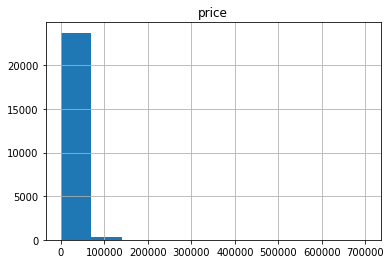

In [87]:
airbnb.hist('price')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7be5596a58>]],
      dtype=object)

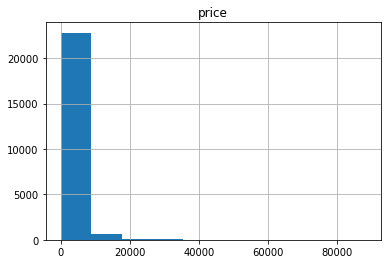

In [88]:
airbnb_aux = airbnb[airbnb['price']< 90000]
airbnb_aux.hist('price')

In [10]:
airbnb_aux = airbnb_aux.to_crs(epsg=4326)

Combinamos el data set de Barrios y bocas de subtes.

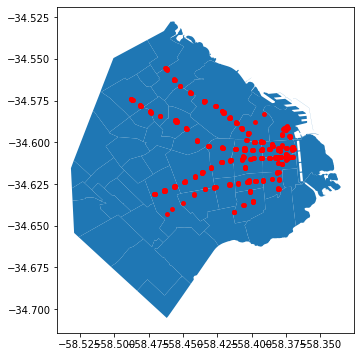

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
barrios.plot(ax=ax)
subtes.plot(ax=ax, color = 'red',markersize = 15)
plt.show()

combinamos el dataset de airbnb y barrios (poligonos) para crear un mapa con delimitacion de los barrios y precios.
Calculamos el total de departamentos disponibles por barrio.

In [185]:
joines = geopandas.sjoin(airbnb, barrios, op='within')
alquileres_por_barrio = joines.groupby('neighbourhood_left').size()
alquileres_por_barrio = alquileres_por_barrio.to_frame(name='total')
pd.DataFrame(alquileres_por_barrio, index = None).head()


,total
neighbourhood_left,
Agronomia,31
Almagro,985
Balvanera,1171
Barracas,167
Belgrano,1110


Usando los datos de los poigonos, podemos usar el AREA de cada barrio para saber la densidad de departamentos en alquiler por metro cuadrado.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


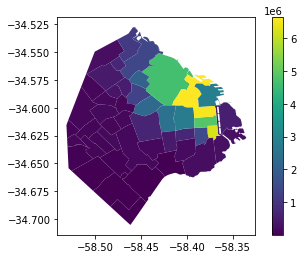

   neighbourhood neighbourhood_group  ... total      densidad
6       Recoleta                None  ...  4007  6.641459e+06
46   San Nicolas                None  ...  1471  6.539613e+06
33     San Telmo                None  ...   755  6.233711e+06
45     Monserrat                None  ...  1053  4.873129e+06
2        Palermo                None  ...  7229  4.665669e+06
7         Retiro                None  ...  1260  2.828190e+06
30     Balvanera                None  ...  1171  2.744079e+06
13       Almagro                None  ...   985  2.474301e+06
1   Villa Crespo                None  ...   794  2.236067e+06
27    Colegiales                None  ...   465  2.067253e+06

[10 rows x 5 columns]


In [205]:

barrios_alquileres = barrios.merge(alquileres_por_barrio, left_on='neighbourhood', right_on='neighbourhood_left')
barrios_alquileres['densidad'] = barrios_alquileres.total / barrios_alquileres.geometry.area
barrios_alquileres.plot(column = 'densidad', legend = True, label = 'neighbourhood')
plt.show()
print(barrios_alquileres.sort_values('densidad', ascending=False).head(10))

Total de departemento por barrio.

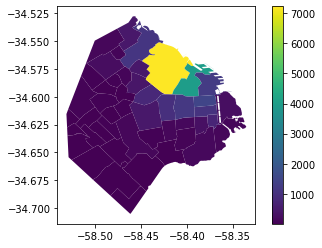

   neighbourhood  ... total
2        Palermo  ...  7229
6       Recoleta  ...  4007
46   San Nicolas  ...  1471
7         Retiro  ...  1260
30     Balvanera  ...  1171

[5 rows x 4 columns]


In [207]:
barrios_alquileres = barrios.merge(alquileres_por_barrio, left_on='neighbourhood', right_on='neighbourhood_left')
barrios_alquileres.plot(column = 'total', legend = True, label = 'neighbourhood')
plt.show()
print(barrios_alquileres.sort_values('total',ascending=False).head(5))